# Testing Area Weighting Methods

Check and compare methods and oisstool functions for processing area-weighted averages.

The two methods come from Julius Busecke via ocean hack week 2021, and the xarray documentation. Both of the methods work and create identical outputs using oisst data, but have been commented out to test the oisstools implementation

In [3]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask
import math
import oisstools as ot

# Set the workspace - local/ docker
box_root = ot.set_workspace("local")

# variable name to mask and make timeline from
var_name = "sst"

## Load OISST

In [68]:
# Years to Include
start_yr = 2000
end_yr = 2020

# Load OISSt using ot.load_box_oisst()
oisst_grid = ot.load_box_oisst(box_root, 
                               start_yr, 
                               end_yr, 
                               anomalies = False, 
                               do_parallel = True)

# Add MOD
oisst_grid = ot.add_mod(oisst_grid, time_dim = "time")


# Subset temperature and a reduced time period to test
grid_obj = oisst_grid.sst.sel(time=slice("2018-01-01", "2020-12-31"))

## Method 1 - Ocean Hack Week

https://www.youtube.com/watch?v=g0GKqYkp9kk&list=PLA6PlfxWZPLTPQ_OIr3dDPF9FRiHQXoVF&index=2&t=1433s

In [5]:
# # Method 1: From Julius Busecke
# delta_lon = np.cos(grid_obj.lat * np.pi / 180) * 111e3
# delta_lat = xr.ones_like(grid_obj.lon) * 111e3
# cell_area = delta_lon * delta_lat

# # Apply weights
# grid_j_wted = grid_obj.weighted(cell_area)
# grid_j_wted

In [6]:
# # Compare methods visually
# grid_j_wted.mean(("lat", "lon")).plot(label = "Julius Weighting",  )
# grid_obj.mean(("lon", "lat")).plot(label = "unweighted")

# plt.legend()

## Method 2 - xr Documentation

Source: xarray docs
http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html

In [7]:
# # Weighting using the formula on the xarray example
# weights = np.cos(np.deg2rad(grid_obj.lat))
# weights.name = "weights"

# # weight the array with the areas
# grid_weighted = grid_obj.weighted(weights)
# grid_weighted

In [8]:
# # Compare methods visually
# grid_weighted.mean(("lat", "lon")).plot(label = ".weighted")
# grid_obj.mean(("lon", "lat")).plot(label = "unweighted")

# plt.legend()

## oisstools testing

In [9]:
# Start at the same point as above
ot_test_grid = oisst_grid.sel(time = slice("2015-01-01", "2020-12-31"))

# Use ot.area_weighted_means - to get weighted means
ot_wtd_mean = ot.area_weighted_means(ot_test_grid, var_name = "sst")
ot_wtd_mean

Processing Area-Weighted Means


<xarray.Dataset>
Dimensions:       (time: 731)
Coordinates:
  * time          (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-12-31
    MOD           (time) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    area_wtd_sst  (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>

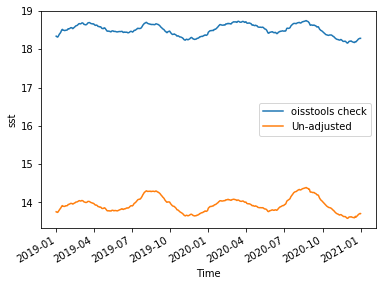

In [11]:
# Plot Check
ot_wtd_mean.area_wtd_sst.plot(label = "oisstools area-weighting")
ot_test_grid.sst.mean(("lat", "lon")).plot(label = "Un-adjusted")
plt.legend()

## Success!

---

# Standard Deviations

In [9]:
# Standard Deviations - not possible
ot_wtd_sd = ot.area_weighted_means(ot_test_grid, var_name = "sst", sd = True)
ot_wtd_sd.plot(label = "Standard Deviation")

Processing Area-Weighted Standard Deviations


AttributeError: 'DataArrayWeighted' object has no attribute 'std'

---

# Masked SST and Masked Climatology

For some of our workflows we estimate an area masked climate and standard deviation. The oisstools function needs to capture that functionality and name things accordingly.

In [60]:
# Option 1.
update_regions = "gmri_sst_focal_areas"
region_names = ot.get_region_names(region_group = update_regions)
region_names

# pick one
mask_name = region_names[0]
mask_name


'apershing_gulf_of_maine'

In [61]:
# Get paths to each shapefile
mask_paths = ot.get_timeseries_paths(box_root = box_root, 
                                     region_list = region_names, 
                                     region_group = update_regions, 
                                     polygons = True)
mask_path = mask_paths[0]
mask_path 

'/Users/akemberling/Box/RES_Data/Shapefiles/gmri_sst_focal_areas/apershing_gulf_of_maine.geojson'

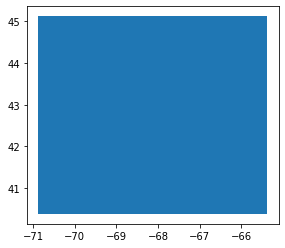

In [62]:
# Use paths to make list of loaded polygons
mask_shp = gpd.read_file(mask_path)
mask_shp.plot()

## Processing Area Weighted SST

In [70]:
grid_obj = oisst_grid.sel(time=slice("2018-01-01", "2020-12-31"))

# Get masked timeseries of climatology
masked_temp = ot.calc_ts_mask(grid_obj = grid_obj, 
                              shp_obj  = mask_shp, 
                              shp_name = mask_name,
                              var_name = "sst",
                              climatology = False)
masked_temp.tail()

Processing Area-Weighted Means


,time,area_wtd_sst,sst
1091,2020-12-27,8.540225,8.525442
1092,2020-12-28,8.351438,8.338260
1093,2020-12-29,8.097193,8.085349
1094,2020-12-30,8.193081,8.181045
1095,2020-12-31,8.233084,8.222437


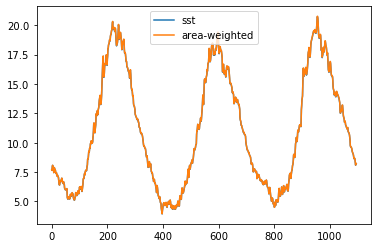

In [71]:
masked_temp.sst.plot(label = "sst")
masked_temp.area_wtd_sst.plot(label = "area-weighted")
plt.legend()

## Processing Masked Climatology

In [33]:
# Load the OISST Climatology
oisst_clim = ot.load_oisst_climatology(box_root, reference_period = "1982-2011")

# Get masked timeseries of climatology
masked_clim = ot.calc_ts_mask(grid_obj = oisst_clim, 
                              shp_obj  = mask_shp, 
                              shp_name = mask_name,
                              var_name = "sst",
                              climatology = True)

Processing Area-Weighted Means


In [44]:
masked_clim.tail()

,modified_ordinal_day,area_wtd_clim,sst_clim,clim_sd
361,362,26.913090,26.793530,2.359603
362,363,26.945328,26.826296,2.349905
363,364,26.958380,26.839521,2.347488
364,365,26.949793,26.832155,2.327945
365,366,26.950603,26.834196,2.304104


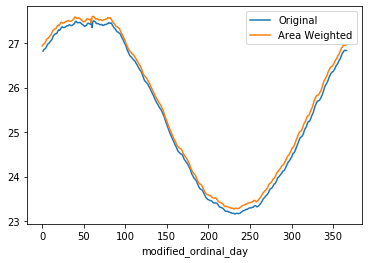

In [50]:
# Inspect
masked_clim.plot(x = "modified_ordinal_day", y = "sst_clim", label = "Original")
masked_clim.area_wtd_clim.plot(label = "Area Weighted")
plt.legend()